# You need to use numan kernel!!

In [2]:
import vodex as vx
import numan as nu
import Voxelizer
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

import models, analysis

In [2]:
base_folder = "/Volumes/Group Share/Neuroanalysis/Numerosity/1v2v3v4v5_H2B/"
folders = [base_folder + "20230207_hb01_casper_h2bcamp7f_5dpf_2P_1v2v3v4v5_processed",
           base_folder + "20230209_hb03_casper_h2bcamp7f_7dpf_2P_1v2v3v4v5_1_processed",
           base_folder + "20230209_hb04_casper_h2bcamp7f_7dpf_2P_1v2v3v4v5_1_processed",
           base_folder + "20230207_hb07_casper_h2bcamp7f_5dpf_2P_1v2v3v4v5_1_processed",
           base_folder + "20230301_hb08_casper_h2bcamp7f_5dpf_2P_1v2v3v4v5_1_processed",
           base_folder + "20230301_hb09_casper_h2bcamp7f_5dpf_2P_1v2v3v4v5_1_processed",
           base_folder + "20230303_hb10_casper_h2bcamp7f_7dpf_2P_1v2v3v4v5_1_processed",
           base_folder + "20230303_hb11_casper_h2bcamp7f_7dpf_2P_1v2v3v4v5_1_processed",
           base_folder + "20230303_hb12_casper_h2bcamp7f_7dpf_2P_1v2v3v4v5_1_processed"]

# Loop to merge all cells from different sample. Note: this will work only if the presentation modality is the same, always same order and numebr of presenatation (trials)!!!!

In [4]:
for count,f in enumerate(folders):
    print('Processing: '+f)
    project_folder = f
    os.chdir(f+'/processed/')

    my_spots = nu.Spots.from_json("spots/signals/spots_SvB_max.json")
    dff = my_spots.signals.as_dff(15)
    signals = dff.traces.T
    #print(signals.shape)
    
    experiment = vx.Experiment.load("experiment_w_covariates_raw.db")
    stim_volumes = experiment.choose_volumes([("number","d1"), ("number","d2"), ("number","d3"),("number","d4"), ("number","d5")], logic = "or")
    stim_signal=signals[:,stim_volumes]
    print('cells X trials: ' + str(stim_signal.shape)+'\n')
    
    annotation_dict2= {f"cell_{ic}": stim_signal[ic] for ic in np.arange(len(signals))}
    annotation_dict=experiment.get_volume_annotations(stim_volumes)
    annotation_dict.update(annotation_dict2)
    annotation_df=pd.DataFrame(annotation_dict)
    #print(annotation_df.shape)
    
    Hf = np.array(annotation_df.iloc[:, 4:annotation_df.shape[1]])
    if count==0:
        final_Hf = Hf
    else:
        final_Hf = np.append(final_Hf, Hf, 1)
print('Total trials X cells: ' + str(final_Hf.shape))

Q_pd = pd.factorize(annotation_df['number'], sort=True)
labelQ = Q_pd[1]
print(labelQ)
Q = np.array(Q_pd[0])
#print(Q)
print(Q.shape)

C_pd = pd.factorize((annotation_df['shape']+ annotation_df['spread']), sort=True)
#C_pd = pd.factorize((annotation_df['shape']), sort=True)
labelC = C_pd[1]
print(labelC)
C = np.array(C_pd[0])
#print(C)
print(C.shape)

#/Volumes/Group Share/Neuroanalysis/Numerosity/1v2v3v4v5_H2B/20230207_hb02_casper_h2bcamp7f_5dpf_2P_1v2v3v4v5_1_processed

Processing: /Volumes/Group Share/Neuroanalysis/Numerosity/1v2v3v4v5_H2B/20230207_hb01_casper_h2bcamp7f_5dpf_2P_1v2v3v4v5_processed
cells X trials: (141, 240)

Processing: /Volumes/Group Share/Neuroanalysis/Numerosity/1v2v3v4v5_H2B/20230209_hb03_casper_h2bcamp7f_7dpf_2P_1v2v3v4v5_1_processed
cells X trials: (93, 240)

Processing: /Volumes/Group Share/Neuroanalysis/Numerosity/1v2v3v4v5_H2B/20230209_hb04_casper_h2bcamp7f_7dpf_2P_1v2v3v4v5_1_processed
cells X trials: (86, 240)

Processing: /Volumes/Group Share/Neuroanalysis/Numerosity/1v2v3v4v5_H2B/20230207_hb07_casper_h2bcamp7f_5dpf_2P_1v2v3v4v5_1_processed


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Group Share/Neuroanalysis/Numerosity/1v2v3v4v5_H2B/20230207_hb07_casper_h2bcamp7f_5dpf_2P_1v2v3v4v5_1_processed/processed/'

## run this if you want to save final data matrix

In [21]:
final_labels = np.stack((C,Q),axis=1)
total_df = np.concatenate((final_labels, final_Hf),axis=1)
total_df.shape
np.savetxt('/Users/mirckuz/Desktop/stimulus_final_table.csv', total_df, delimiter=',')

# Nieder's analysis

In [22]:
# Configuration parameters

Qrange = np.array([0,1,2,3,4]) # range of tested numerosities
colors = ['red', 'orange', 'green', 'blue', 'purple'] # plotting colors for numerosities in Qrange

matplotlib.rcParams.update({'font.size': 7.65}) # plot font size

In [23]:
# Find numorosity selective units (anova_cells) using a two-way ANOVA
pN, pC, pNC = analysis.anova_two_way(Q, C, Hf)
anova_cells = np.where((pN<0.01) & (pNC>0.01) & (pC>0.01))[0]
R = Hf[:,anova_cells]

Number of anova cells = 103 (82.40%)


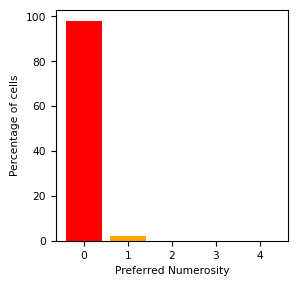

In [24]:
# Calculate and plot ditribution of preferred numerosities
pref_num = analysis.preferred_numerosity(Q, R)
hist = [np.sum(pref_num==q) for q in Qrange]
hist /= np.sum(hist)

plt.figure(figsize=(3,3))
plt.bar(Qrange, 100*hist, width=0.8, color=colors)
plt.xlabel('Preferred Numerosity')
plt.ylabel('Percentage of cells')
print('Number of anova cells = %i (%0.2f%%)'%(len(anova_cells), 100*len(anova_cells)/Hf.shape[1]))

/opt/anaconda3/envs/Imaging/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/Imaging/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/envs/Imaging/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/Imaging/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/Imaging/lib/python3.8/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/envs/Imaging/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting 

Text(0, 0.5, 'Normalized Neural Activity')

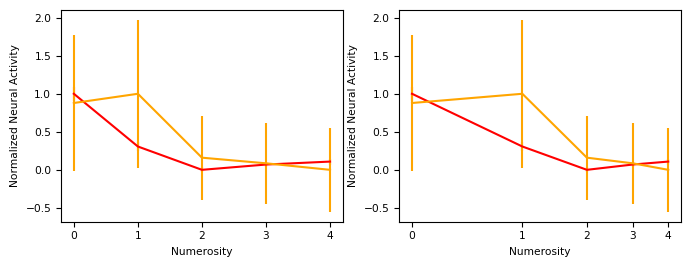

In [25]:
# Calculate average tuning curve of each unit
tuning_curves = analysis.average_tuning_curves(Q, R) 

# Calculate population tuning curves for each preferred numerosity
tuning_mat = np.array([np.mean(tuning_curves[:,pref_num==q], axis=1) for q in Qrange]) # one row for each pref numerosity
tuning_err = np.array([np.std(tuning_curves[:,pref_num==q], axis=1) / np.sqrt(np.sum(pref_num==q)) # standard error for each point on each tuning curve
                       for q in Qrange])

# Normalize population tuning curves to the 0-1 range
tmmin = tuning_mat.min(axis=1)[:,None]
tmmax = tuning_mat.max(axis=1)[:,None]
tuning_mat = (tuning_mat-tmmin) / (tmmax-tmmin)
tuning_err = tuning_err / (tmmax-tmmin) # scale standard error to be consistent with above normalization

# Plot population tuning curves on linear scale
plt.figure(figsize=(8,2.75))
plt.subplot(1,2,1)
for i, (tc, err) in enumerate(zip(tuning_mat, tuning_err)):
    plt.errorbar(Qrange, tc, err, color=colors[i])
    plt.xticks(Qrange)
plt.xlabel('Numerosity')
plt.ylabel('Normalized Neural Activity')

# Plot population tuning curves on log scale
plt.subplot(1,2,2)
for i, (tc, err) in enumerate(zip(tuning_mat, tuning_err)):
    plt.errorbar(Qrange+1, tc, err, color=colors[i]) # offset x axis by one to avoid taking the log of zero
    plt.xscale('log', base=2)
    plt.gca().xaxis.set_major_formatter(ScalarFormatter())
    plt.xticks(ticks=Qrange+1, labels=Qrange)
plt.xlabel('Numerosity')
plt.ylabel('Normalized Neural Activity')